

## KMeans Clustering
- https://medium.com/@brandonsegal/data-science-for-wedding-planning-d1e8e23c43fe
- https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/

## Simulated Annealing
- https://github.com/ZhijingEu/Wedding-Seating-Problem-Simulated-Annealing
- https://stackoverflow.com/questions/41195058/table-seating-what-algorithm-to-use

## Genetic Algorithm
- https://github.com/meganstiles/Seating_Chart

## General Results
- https://github.com/search?q=Wedding-Seat-Optimization&type=code
- https://medium.com/analytics-vidhya/building-a-wedding-seating-plan-using-probabilistic-methods-simulated-annealing-8f31d8987026

In [ ]:
!pip install networkx
!pip install k_means_constrained

In [3]:
import numpy as np
import random
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
# from pulp import *


items = 33
friend = 3
Freunde_m = np.zeros((items, items), dtype=np.int8)
connect_list = [[[i], random.sample(range(0, items), friend)] for i in range(0, items)]
for connect in connect_list:
    Freunde_m[connect[0][0], connect[1]] = 1
Freunde_m
F3 = Freunde_m

In [4]:
Kinder = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
# construct a dictionary for each Kind as keys and three remaining Kinder as values
# Freunde = {Kind: random.sample([x for x in Kinder if x != Kind], 3) for Kind in Kinder}
Freunde = {}
Freunde['A'] = ['D', 'G', 'J']
Freunde['B'] = ['A', 'E', 'H']
Freunde['C'] = ['F', 'I', 'L']
Freunde['D'] = ['A', 'J', 'G']
Freunde['E'] = ['B', 'H', 'K']
Freunde['F'] = ['C', 'I', 'B']
Freunde['G'] = ['A', 'D']
Freunde['H'] = ['G', 'B', 'K']
Freunde['I'] = ['C', 'F', 'K']
Freunde['J'] = ['A', 'N', 'I']
Freunde['K'] = ['H', 'N', 'J']
Freunde['L'] = ['M', 'I']
Freunde['M'] = ['L', 'N', 'O']

Freunde['N'] = ['A', 'Q', 'T']
Freunde['O'] = ['R', 'U']
Freunde['P'] = ['S', 'V', 'Y']
Freunde['Q'] = ['N', 'R', 'T']
Freunde['R'] = ['O', 'U', 'X']
Freunde['S'] = ['P']
Freunde['T'] = ['N', 'Q', 'W']
Freunde['U'] = ['O', 'R', 'W']
Freunde['V'] = ['S', 'Y']
Freunde['W'] = ['T', 'U', 'Z']
Freunde['X'] = ['R', 'Z', 'V']
Freunde['Y'] = ['L', 'Z', 'V']
Freunde['Z'] = ['W', 'T']
# Klassenstufe für jedes Kind
Stufe = {}
Klasse = {}
for indx, Kind in enumerate(Kinder):
    Stufe[Kind] = indx%3 + 1
for indx, Kind in enumerate(Kinder):
    if round(len(Kinder)/2)%(indx+1) < round(len(Kinder)/2):
        Klasse[Kind] =  '+' # 0
    else:
        Klasse[Kind] =  '-' # 1
# random assignment of sexes
Geschlecht = {Kind: random.choice(['M', 'W']) for Kind in Kinder}
# Generating reference files
Kinder_df = pd.DataFrame([Klasse, Stufe, Geschlecht], index=['Klasse','Stufe','Geschlecht']).T
Kinder_df.to_excel('Schueler.xlsx')
Freunde_df = pd.DataFrame([Freunde], index=['Freunde']).T
Freunde_df.to_excel('Freunde.xlsx')


# mapping each name to a unique identifier of form 'LetterNumber'
# e.g. 'A1', 'B2', 'C3', etc.
# IdMapper = {Kind: f'{indx}:{Klasse[Kind]}:{Geschlecht[Kind]}:{Stufe[Kind]}' for indx, Kind in enumerate(Kinder)}


# KindInfo = [f'{IdMapper[Kind]}:{Klass}:{Sex}' for Kind, Klass, Sex in zip(Kinder, Klasse.values(),Geschlecht.values())]

In [4]:
# load the data from xls file
Kinder_df = pd.read_excel('Neuverteilung 2023.xlsx', index_col=None).rename_axis('ID').reset_index()
Kinder_df = Kinder_df.rename(columns = {'Geschl.':'Geschlecht'})

Freunde_df = pd.read_excel('antworten_angepasst_2.xlsx', index_col=None)#.rename_axis('ID').reset_index()
# https://stackoverflow.com/questions/52547805/how-to-convert-dataframe-to-dictionary-in-pandas-without-index
Freunde = Freunde_df.set_index('Vorname')['Freunde'].to_dict()

# Anonymize the data
Kinder_df['Anonym'] = Kinder_df.apply(lambda x: f'{x.ID}:{x.Klasse}:{x.Geschlecht}:{x.Stufe}', axis=1)
# storing the anomymized data in a dictionary
IdMapper = {Kind.Name.strip(): Kind.Anonym for _, Kind in Kinder_df.iterrows()}
IdMapper = {key.strip(): value for key, value in IdMapper.items()}

# mapping the anonymized data to the friends
Mapped = {}
for Kindi in Kinder_df.Name:
    try:
        Mapped[IdMapper[Kindi.strip()]] = [IdMapper[Freund.strip()] for Freund in Freunde[Kindi.strip()].split(',')]
        # print(Mapped[Kindi])
    except KeyError:
        Mapped[IdMapper[Kindi.strip()]] = []

In [5]:
# combining keys ad values of Freunde to a list
Freunde_list = []
for Kind in Mapped:
    for Freund in Mapped[Kind]:
        Freunde_list.append([Kind, Freund])


# cluster Freunde_list to a matrix
Freunde_m = np.zeros((len(Kinder_df.ID), len(Kinder_df.ID)), dtype=np.int8)
for connect in Freunde_list:
    Freunde_m[list(Mapped.keys()).index(connect[0]), list(Mapped.keys()).index(connect[1])] = 1
# setting the diagonal in Freune_m to one
np.fill_diagonal(Freunde_m, 1)
Freunde_m

Freunde_m

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int8)

In [6]:
def generate_color_map(Klasse, Klasse_Color = {'+':'blue', '=':'green','*':'red','?':'yellow', '!':'black', '-':'cyan'}):
    return [Klasse_Color[Klass] for Klass in Klasse]

KlasseNumEncoding = {0:'+', 1:'*', 2:'=', 3:'?', 4:'!', 5:'-'}

Freundschaften: 146
Kinder: 88


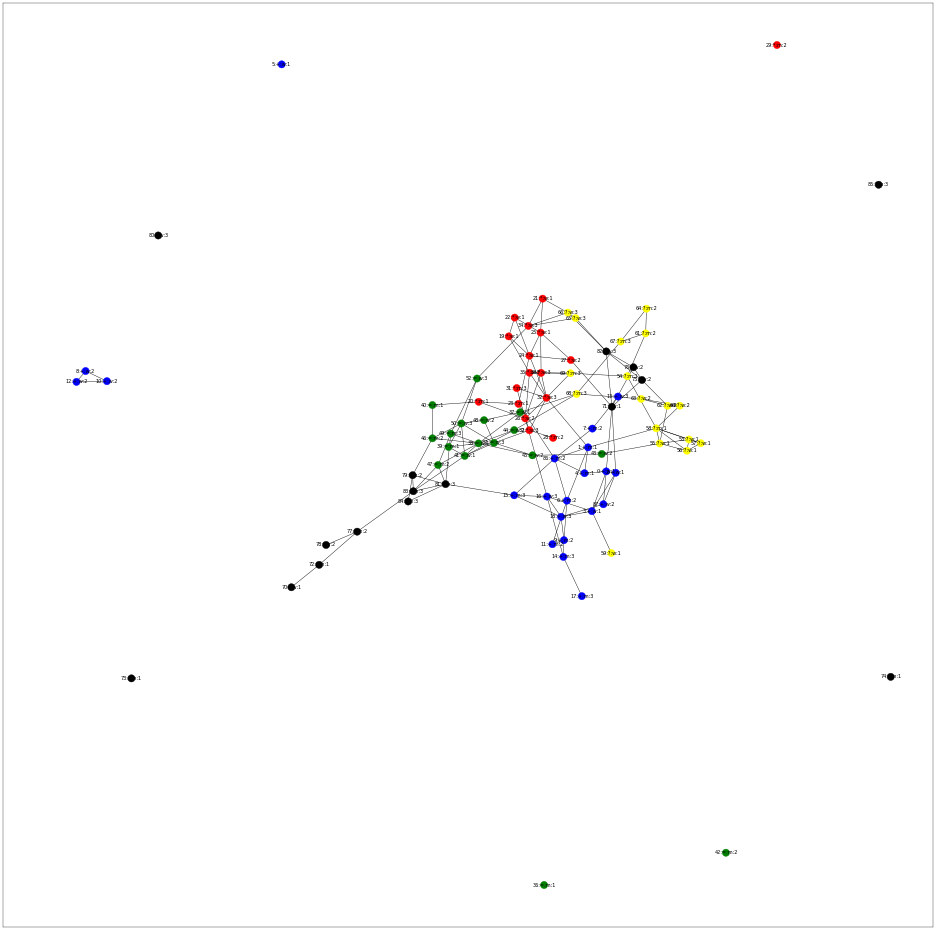

In [13]:
fig = plt.figure(1, figsize=(40, 40), dpi=30)
G = nx.Graph()
# pos=nx.spring_layout(G)
G.add_nodes_from(Kinder_df.Anonym)
G.add_edges_from(Freunde_list)
# G.add_node('101:+:m:2')
KlassExp = [node.split(':')[1] for node in G]
color_map = generate_color_map(KlassExp)
nx.draw_networkx(G, with_labels = True, node_color =color_map)
print(f'Freundschaften: {G.number_of_edges()}')
print(f'Kinder: {G.number_of_nodes()}')

In [14]:
# # using scikit-learn to cluster Freunde_m
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=3, random_state=0).fit(Freunde_m)
# print(kmeans.labels_)
# # # visualizing the clustering
# # plt.imshow(kmeans.labels_.reshape(3, 9), cmap='hot', interpolation='nearest')

# https://towardsdatascience.com/advanced-k-means-controlling-groups-sizes-and-selecting-features-a998df7e6745
from k_means_constrained import KMeansConstrained
clf = KMeansConstrained(
     n_clusters=6,
     size_min=13,
     size_max=20,
     random_state=0
)
clf.fit_predict(Freunde_m)
print(clf.cluster_centers_)
print(clf.labels_)


[[ 6.93889390e-18  1.38777878e-17  6.93889390e-18  1.38777878e-17
   3.46944695e-18  1.38777878e-17  6.93889390e-18  6.93889390e-18
   1.38777878e-17  6.93889390e-18  3.46944695e-18  5.00000000e-02
   1.38777878e-17  5.00000000e-02  1.38777878e-17  6.93889390e-18
   2.77555756e-17  5.00000000e-02  1.38777878e-17  6.93889390e-18
   6.93889390e-18  1.38777878e-17  1.38777878e-17  6.93889390e-18
  -1.38777878e-17  1.38777878e-17  2.77555756e-17  3.46944695e-18
   5.00000000e-02  5.00000000e-02  5.00000000e-02  3.46944695e-18
  -1.38777878e-17  1.38777878e-17  2.77555756e-17  1.38777878e-17
   6.93889390e-18  2.77555756e-17  6.93889390e-18 -1.38777878e-17
   5.00000000e-02  3.46944695e-18  3.46944695e-18  5.00000000e-02
   5.00000000e-02  6.93889390e-18  1.38777878e-17  6.93889390e-18
  -1.38777878e-17  1.38777878e-17  3.46944695e-18  1.38777878e-17
   3.46944695e-18  1.38777878e-17  1.38777878e-17  1.38777878e-17
  -1.38777878e-17  5.00000000e-02  1.38777878e-17  1.38777878e-17
   1.38777

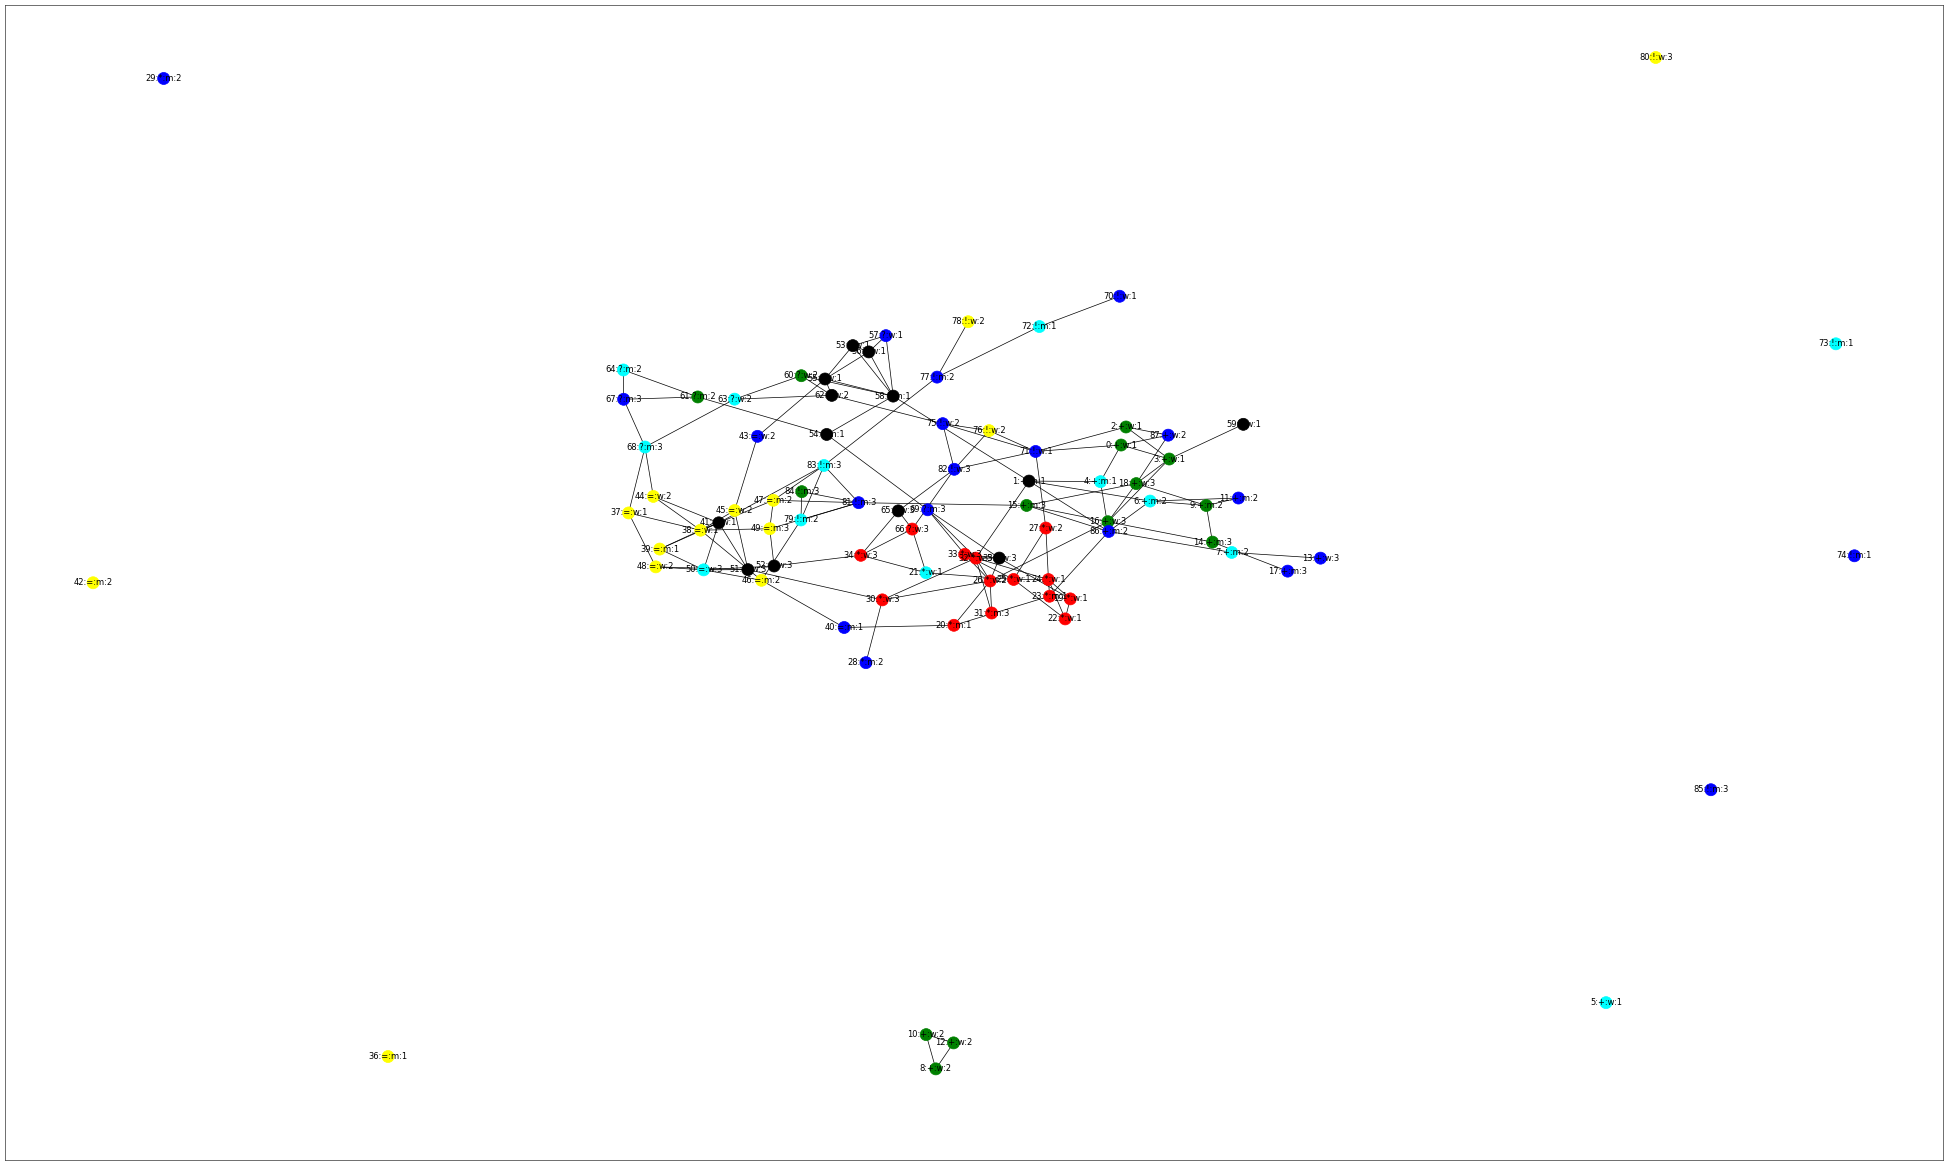

In [20]:
fig = plt.figure(1, figsize=(50, 30), dpi=50)
G = nx.Graph()
G.add_nodes_from(Kinder_df.Anonym)
G.add_edges_from(Freunde_list)
KlassExp = [KlasseNumEncoding[new] for new in clf.labels_]
color_map = generate_color_map(KlassExp)
nx.draw_networkx(G, with_labels = True, node_color =color_map)